In [1]:
import polars as pl
from helpers import match_organisations
from IPython.display import display, Markdown
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import tqdm
import multiprocessing

import seaborn as sns
import matplotlib.pyplot as plt
import squarify  # You'll need to install this: pip install squarify
import numpy as np


In [2]:
df_tax = pl.read_csv("data/ZER-Förderung des demokratischen Staatswesens-20250404.csv", separator=";", null_values=["-"])

In [3]:
df_fund = pl.read_excel("data/Demokratische Finanzierung vom Bund.xlsx",schema_overrides={"__UNNAMED__2": pl.Utf8})

In [4]:
df_fund = df_fund.with_columns(
    (pl.when(pl.col("__UNNAMED__2").cast(pl.Utf8).str.contains(r"^\d+\.\d$"))
    .then(pl.col("__UNNAMED__2").cast(pl.Utf8) + "00") ## if there is one decimal places add one zero
    .when(pl.col("__UNNAMED__2").cast(pl.Utf8).str.contains(r"^\d+\.\d\d$")) 
    .then(pl.col("__UNNAMED__2").cast(pl.Utf8) + "0")
    .when(pl.col("__UNNAMED__2").cast(pl.Utf8).str.contains(r"^\d+\.0$"))
    .then(pl.col("__UNNAMED__2").cast(pl.Utf8).str.replace(r"\.0$", ""))
    .otherwise(pl.col("__UNNAMED__2").cast(pl.Utf8))
    .str.replace_all(r"\.", "")
    .cast(pl.Int64) * 1000)
    .alias("amount")
)

In [5]:
def parallel_match(row):
    return match_organisations(row["__UNNAMED__1"], row["Organisation"])

def process_batch(batch):
    return [parallel_match(row) for row in batch]

def match_with_concurrency(df_fund, df_tax, max_workers=None, batch_size=5000, chunksize=None):
    if max_workers is None:
        # For IO-bound tasks, you can use many more threads than CPU cores
        max_workers = min(32 * multiprocessing.cpu_count(), 512)  # Cap at reasonable maximum

    print(f"Using {max_workers} threads with batch size {batch_size}")

    cross_df = df_fund.join(df_tax, how="cross")
    rows = cross_df.select(["__UNNAMED__1", "Organisation"]).to_dicts()

    batches = [rows[i:i + batch_size] for i in range(0, len(rows), batch_size)]
    total_pairs = len(rows)
    print(f"Processing {total_pairs} organization pairs in {len(batches)} batches")

    match_results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        map_args = dict(chunksize=chunksize) if chunksize else {}

        for batch_result in tqdm.tqdm(
            executor.map(process_batch, batches, **map_args),
            total=len(batches),
            desc="Matching organizations"
        ):
            match_results.extend(batch_result)

    cross_df = cross_df.with_columns([pl.Series("match_result", match_results)])
    matched_df = cross_df.filter(pl.col("match_result"))
    matched_df = matched_df.drop("match_result")

    return matched_df

matched_df = match_with_concurrency(
    df_fund, 
    df_tax,
    max_workers=multiprocessing.cpu_count() * 2,      
    batch_size=500, 
    chunksize=1
)

matched_df = matched_df.filter(
    pl.col("__UNNAMED__2").is_not_null() &
    (pl.col("__UNNAMED__2").cast(pl.Utf8).str.len_chars() != 0)
)

Using 32 threads with batch size 500
Processing 7873864 organization pairs in 15748 batches


Matching organizations: 100%|██████████| 15748/15748 [00:03<00:00, 4352.14it/s]


In [6]:
matched_df.sample(10)[["__UNNAMED__2", "amount"]]

__UNNAMED__2,amount
str,i64
"""105""",105000
"""54""",54000
"""40""",40000
"""89""",89000
"""54""",54000
"""40""",40000
"""696""",696000
"""622""",622000
"""200""",200000


In [7]:
total_amount = df_fund["amount"].sum()
formatted_total = f"{total_amount:,}".replace(",", ".")

display(Markdown(f"**Total amount of funds sent to NGOs in 2023:** {formatted_total}"))

amount = matched_df["amount"].sum()
formatted = f"{amount:,}".replace(",", ".")

display(Markdown(f"**Total amount of funds sent to NGOs that support democracy in 2023:** {formatted}"))

percentage = str(round((amount/total_amount)*100,2))+"%"
print(f"This is {percentage} of the total amount.")

**Total amount of funds sent to NGOs in 2023:** 3.335.291.000

**Total amount of funds sent to NGOs that support democracy in 2023:** 369.669.000

This is 11.08% of the total amount.


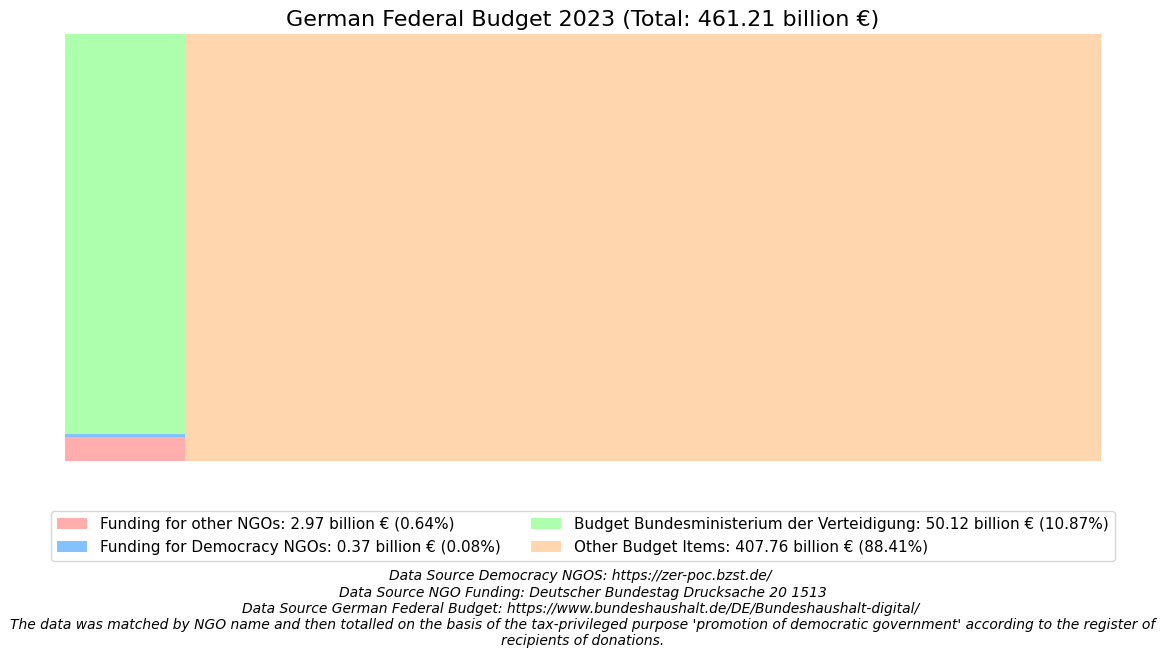

In [43]:
# https://www.bundeshaushalt.de/DE/Bundeshaushalt-digital/bundeshaushalt-digital.html
total_2023_budget = 461211782000  # Total German Federal Budget 2023
military = 50117445000  # Defense Ministry budget 2023

rest_budget = total_2023_budget - military - total_amount 
other_ngo_funding = total_amount - amount

# Define labels and sizes
labels = ['Funding for other NGOs', 
          'Funding for Democracy NGOs', 
          "Budget Bundesministerium der Verteidigung", 
          'Other Budget Items']

sizes = [other_ngo_funding, amount, military, rest_budget]

colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

total = sum(sizes)
percentages = [f"{(size/total)*100:.2f}%" for size in sizes]
formatted_values = [f"{size/1e9:.2f} billion €" for size in sizes]

legend_labels = [f"{l}: {v} ({p})" for l, v, p in zip(labels, formatted_values, percentages)]

plt.figure(figsize=(12, 8))

ax = squarify.plot(sizes=sizes, label=None, color=colors, alpha=0.8)

plt.legend(handles=ax.containers[0], labels=legend_labels, 
           loc='upper center', bbox_to_anchor=(0.5, -0.1),
           ncol=2, frameon=True, fontsize=11)

ax.axis('off')
plt.title(f'German Federal Budget 2023 (Total: {total_2023_budget/1e9:.2f} billion €)', fontsize=16)

# Add plot description at the bottom

description = (
               "Data Source Democracy NGOS: https://zer-poc.bzst.de/ \n"
               "Data Source NGO Funding: Deutscher Bundestag Drucksache 20 1513\n"
               "Data Source German Federal Budget: https://www.bundeshaushalt.de/DE/Bundeshaushalt-digital/ \n" 
               "The data was matched by NGO name and then totalled on the basis of the tax-privileged purpose 'promotion of democratic government' according to the register of recipients of donations.")
plt.figtext(0.5, 0.14, description, wrap=True, horizontalalignment='center', 
            fontsize=10, style='italic')

plt.tight_layout(rect=[0, 0.2, 1, 0.95])  # Adjusted to make room for description
plt.show()